# Assignment 2 Digital Management and Image Processing
# Davide Brinati
# Matricola 771458

Il seguente assignment è stato svolto su Google Colab

In [0]:
#Carico i dati su colab
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import cv2 as cv
from matplotlib import pyplot as plt

from skimage import feature

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import MiniBatchKMeans

import numpy as np
from time import time

In [0]:
maximages = 500
nwords = 300
normalize = True

In [0]:
im = cv.imread('/content/gdrive/My Drive/classes/dog500/dog.10014.jpg', 0)

In [6]:
im.shape

(490, 399)

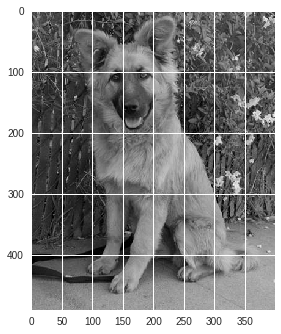

In [7]:
#Esempio di cane
plt.imshow(im, 'gray')

In [0]:
im1 = cv.imread('/content/gdrive/My Drive/classes/cat500/cat.10021.jpg', 0)

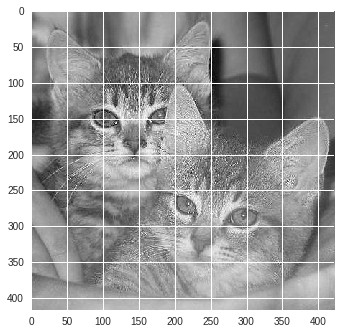

In [9]:
#Esempio di gatti
plt.imshow(im1, 'gray')

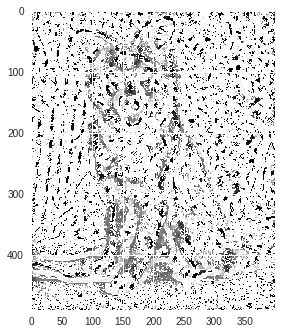

In [10]:
#Esempio LBP
lbp_test = feature.local_binary_pattern(im, P=24, R=8, method="uniform")
plt.imshow(lbp_test, cmap='gray'); plt.show()

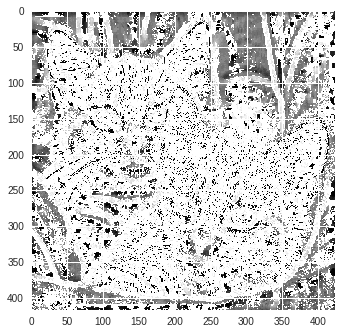

In [11]:
lbp_test = feature.local_binary_pattern(im1, P=24, R=8, method="uniform")
plt.imshow(lbp_test, cmap='gray'); plt.show()

# Data Loader

In [0]:
# Feature dummy
def dummy(image):
    image = cv.resize(image, dsize=(240,240))
    image = feature.local_binary_pattern(image, P=24, R=8, method="uniform")  #Applica LBP
    
    block_height=10                     #Dimensione dei blocchi che scorrono sulle immagini
    block_length=10
    
    histograms = []
    for h in range(0,image.shape[0], 5):
        for l in range(0,image.shape[1], 5):
            window = image[h:h+block_height,l:l+block_height]
            hist = np.histogram(window)[0]
            histograms.append(hist)
    
    histograms=np.array(histograms)
    return histograms

# Data loader
def load_data(feature_extractor=dummy):
    base_path = '/content/gdrive/My Drive/classes/'

    labels = []
    features = []

    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith('.jpg') and fi<maximages:
                # Carica file ed estraine le features
                image = cv.imread(base_path + d + '/' + f, 0)
                cur_features = feature_extractor(image)
                features.append(cur_features)

                # Categorie
                labels.append(di)

    # Separazione training / test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                        test_size=0.3, 
                                                        shuffle=True, 
                                                        random_state=1)
    # X: features, y: labels

    return X_train, X_test, y_train, y_test

## Estraggo features

In [13]:
t0 = time()
X_train, X_test, y_train, y_test = load_data(feature_extractor=dummy)   #Estraggo le features con dummy, che è la funzione che applica LBP
print("Caricamento e feature extraction in %0.3f secondi" % (time() - t0))

Caricamento e feature extraction in 232.649 secondi


In [0]:
X_train_stack = np.zeros((0,X_train[0].shape[1]), dtype=np.float32)
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))

In [0]:
if normalize:
    eps = 0.001
    X_train_mean = X_train_stack.mean(axis=0)
    X_train_std = X_train_stack.std(axis=0)
    X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
    X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]
    
    X_train_stack = (X_train_stack - X_train_mean + eps)/(X_train_std + eps)

## Creo il dizionario Bag of words

In [0]:
dictionary = MiniBatchKMeans(n_clusters=nwords)

In [17]:
t1 = time()
dictionary.fit(X_train_stack)
print("Dizionario creato in %0.3f secondi" % (time() - t1))

Dizionario creato in 73.156 secondi


## Assegno le words

In [0]:
def bow_features(feats, dictionary):
    quantized = dictionary.predict(feats)
    t = np.bincount(quantized, minlength=nwords)
    return t

In [0]:
X_train2 = [bow_features(f, dictionary) for f in X_train]

In [0]:
X_test2 = [bow_features(f, dictionary) for f in X_test]

In [0]:
X_train2 = [hist/hist.sum() for hist in X_train2]
X_test2 = [hist/hist.sum() for hist in X_test2]

<Container object of 300 artists>

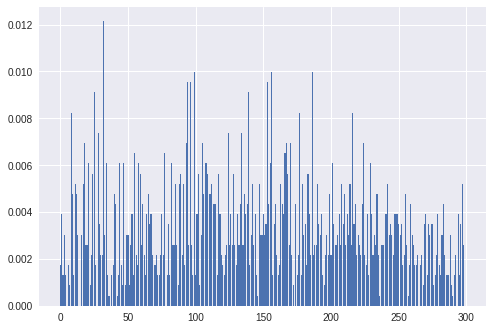

In [22]:
plt.bar(range(0,nwords), X_train2[0])

# ADDESTRAMENTO

### Per fare hyper-tuning dei parametri uso RandomSearch, che in contrapposizione a GridSearch, non prova iterativamente tutti i parametri, ma li campiona da delle distribuzioni date in input

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [0]:
def hypertuning_rscv(mod, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(mod, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5)
    #KFoldsCV con K=5
    start = time()
    rdmsearch.fit(X,y)
    print('hyper-tuning time : %d seconds' % (time()-start))
    start = 0
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [0]:
#Si inizializza la Support Vector Machine
model = SVC(class_weight='balanced', kernel='rbf')

In [0]:
rndmsearch_param_dist = {'C': randint(1, 1001),
                         'gamma': randint(1, 1001)}

In [28]:
model_params, model_best_score = hypertuning_rscv(model, rndmsearch_param_dist, 100, X_train2, y_train)

hyper-tuning time : 110 seconds


In [29]:
model_params['kernel'] = 'rbf'
model_params['class_weight'] = 'balanced'
print(model_params)
print('Hyper-tuned model score :')
print(model_best_score)

{'C': 818, 'gamma': 972, 'kernel': 'rbf', 'class_weight': 'balanced'}
Hyper-tuned model score :
0.7142857142857143


## Test

In [33]:
model = SVC(C=818, gamma=972, kernel='rbf', class_weight='balanced')
model.fit(X_train2, y_train)

SVC(C=818, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=972, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
model.score(X_test2, y_test)

0.71

In [35]:
pred = model.predict(X_test2)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71       149
           1       0.71      0.72      0.71       151

   micro avg       0.71      0.71      0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300



In [0]:
import itertools

def plot_confusion_matrix(cm, classes, target_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

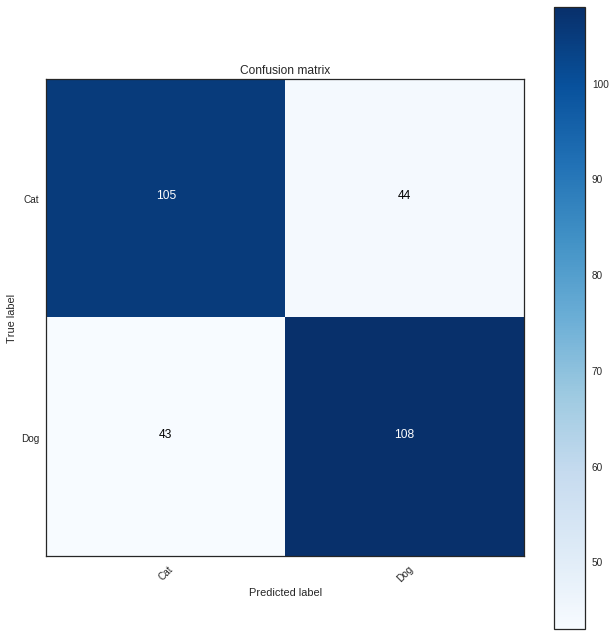

In [40]:
import seaborn as sns

sns.set_style('white')
f, ax = plt.subplots(figsize= (9,9))
cfs_mtx = confusion_matrix(y_test, pred)
plot_confusion_matrix(cfs_mtx, classes=range(1), target_names= ['Cat', 'Dog'])